# Inputs

In [15]:
%load_ext autoreload
%autoreload 2
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from boostlets_mod import Boostlet_syst, sk_to_phys, rm_sk_index_in_horiz_cone
from mod_plotting_utilities import plot_array_images
from mod_RIRIS_func import load_DB_ZEA, rand_downsamp_RIR, ImageOps, jitter_downsamp_RIR, load_sk
from mod_RIRIS_func import computePareto, ista, iffst, linear_interpolation_fft, perforMetrics, calculate_NMSE
np.random.seed(42)

plt.rcParams.update({
    'text.usetex': True,            # Usar LaTeX para todo el texto
    'font.size': 14,                # Tamaño de la fuente general
    'axes.titlesize': 14,           # Tamaño de los títulos de los ejes
    'axes.labelsize': 14,           # Tamaño de las etiquetas de los ejes
    'xtick.labelsize': 14,          # Tamaño de las etiquetas de los ticks del eje x
    'ytick.labelsize': 14,          # Tamaño de las etiquetas de los ticks del eje y
    'legend.fontsize': 14,          # Tamaño de la fuente en las leyendas
    'figure.titlesize': 16,         # Tamaño del título principal de la figura
    'text.latex.preamble': r'\usepackage{amsmath}'  # Permitir usar amsmath en LaTeX
})


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Dictionaries

In [16]:
folders = ['ss_saved_dicts', 'saved_dicts/tan_dicts/M128_bases']
files = [r'SS_m_128_n_128.mat', r'BS_m_128_n_128_vsc_0_hsc_0_bases_0.1_0.1_thV_15_thH_15.mat']
Sks = []
Sk_labels = ['Shearlets', 'Boostlets']

for folder_dict, file_dict in zip(folders, files):
    Sk = load_sk(folder=folder_dict, file=file_dict, build_dict=None)
    Sks.append(Sk)



Loading dictionary
ss_saved_dicts\SS_m_128_n_128.mat
Loading dictionary
saved_dicts/tan_dicts/M128_bases\BS_m_128_n_128_vsc_0_hsc_0_bases_0.1_0.1_thV_15_thH_15.mat


Image

In [17]:
# ---------- LOAD Image ---------------------------
M0, N0 = 100, 100
folder_im = Path(r"dependencies/measurementData")
room = "Balder"
file_im = f"{room}RIR.mat"

ratio_mics = [0.2, 0.33]
Tstarts = [0, 1000]
Tends = [Tstart + M0 for Tstart in Tstarts]  # Corrección de suma

# Construcción de la ruta completa
file_path = folder_im / file_im
print("Image loaded:")
print(file_path)

# Load full image and select a subimage to apply decomposition
full_image = load_DB_ZEA(file_path)[0]

Image loaded:
dependencies\measurementData\BalderRIR.mat


In [18]:

# Seleccionar subimágenes para cada par (Tstart, Tend)
orig_images = [full_image[Tstart:Tend, :N0] for Tstart, Tend in zip(Tstarts, Tends)]



(128, 128)


(128, 128)


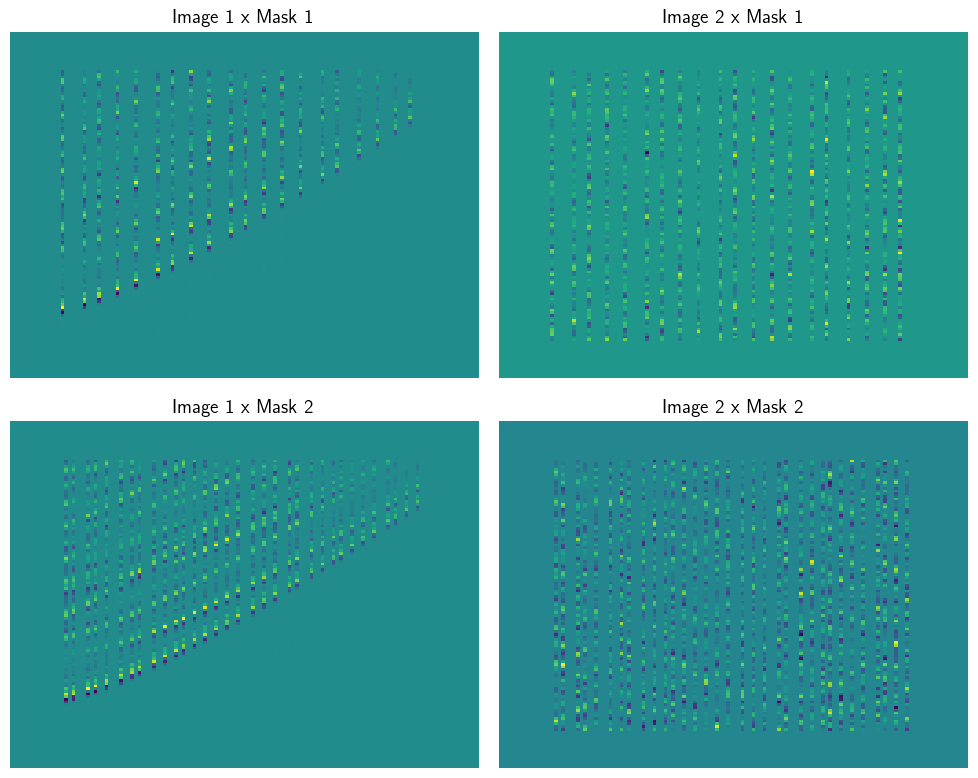

In [19]:
extrap_mode = "pad" # or pad
extr_size = Sks[0].shape[:2]

# Generar máscaras
masks = []
for rm in ratio_mics:
    mask0, mask_t = jitter_downsamp_RIR(orig_images[0].shape, ratio_t=1, ratio_x=rm)
    imOps = ImageOps(orig_images[0].shape, mask=mask0, extrap_shape=extr_size, mode=extrap_mode) 
    mask = imOps.expand_image(mask_t*mask0)
    masks.append( mask )
    print(mask.shape)

# Generar images
images = [imOps.expand_image(img) for img in orig_images]


# Crear la figura y los subgráficos
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

# Mostrar imágenes multiplicadas por las máscaras
for i, mask in enumerate(masks):
    for j, img in enumerate(images):
        ax[i, j].pcolor(img * mask, shading='auto')  # Usar `shading='auto'` para evitar problemas con bordes
        ax[i, j].set_title(f"Image {j+1} x Mask {i+1}")
        ax[i, j].axis('off')  # Opcional: desactivar los ejes para una presentación más limpia

# Ajustar los márgenes y mostrar el gráfico
plt.tight_layout()
plt.show()



Remove elements

In [20]:
fs=11250
cs=340
dx, dt = 3e-2, 1/fs

updated_Sks=[]
indexes_removed=[]
for Sk in Sks:
    rm_sk_ids = rm_sk_index_in_horiz_cone(dx=dx, dt=dt, cs=cs, Sk=Sk)
    indexes_removed.append(rm_sk_ids)
    print(f"Removed IDs: {rm_sk_ids}")
    Sk = np.delete(Sk, rm_sk_ids, axis=2)
    updated_Sks.append(Sk)
Sks = updated_Sks


Removed IDs: [2, 9, 18, 19, 20, 29, 30, 31]
Removed IDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


Pareto

In [21]:
import pandas as pd

beta_set = np.logspace(-2.5, -0.8, 50)
epsilon = 9.4e-6  # ISTA
ls_iterations = list(range(1, 20))

data = []

# Iterar sobre los datos y llenar el dataframe
for image, Tstart, in zip(images, Tstarts):
    for mask, rm in zip(masks, ratio_mics):
        for folder_dict, file_dict, label, Sk, rm_sk_ids in zip(folders, files, Sk_labels, Sks, indexes_removed):
            
            # Almacenar los resultados
            data.append({
                'path': str(file_path),
                'M0': M0,
                'N0': N0,
                'M': Sk.shape[0],
                'N': Sk.shape[1],
                'dx': dx,
                'dt': dt,
                'cs': cs,
                'rm_sk_ids': rm_sk_ids,
                'beta_set': beta_set.tolist(),
                'epsilon': epsilon,
                'ls_iterations': ls_iterations,
                'Tstart': Tstart,
                'rm': rm,
                'label': label,
            })

data_df = pd.DataFrame(data).reset_index(drop=True)


In [22]:
aux_data = []

for image, orig_image, Tstart in zip(images, orig_images, Tstarts):
    for mask, rm in zip(masks, ratio_mics):
        for label, Sk in zip(Sk_labels, Sks):

            # Pareto
            beta_star, Jcurve = computePareto(image, mask, Sk, beta_set, f_plot=False)

            residue_list = []
            NMSE_list = []

            # ISTA
            for max_iter in ls_iterations:
                # Calcular alpha usando ISTA
                alpha = ista(
                    image,
                    mask,
                    Sk,
                    beta=beta_star,  # Uso directo del valor de beta
                    epsilon=epsilon,
                    max_iterations=max_iter,
                    f_plot=False,
                    f_verbose=False,
                )

                # Reconstrucción de la imagen y cálculo del residuo
                image_recov = iffst(alpha, Sk)
                residue = np.linalg.norm((mask * (image - image_recov)).ravel(), 2)
                residue_list.append(residue)

                # Recuperación de la imagen final y cálculo de NMSE
                final_image = imOps.recover_image(image_recov)
                NMSE = calculate_NMSE(orig_image, final_image)
                NMSE_list.append(NMSE)

            aux_data.append({
                'Tstart': Tstart,
                'rm': rm,
                'label': label,
                'beta_star': beta_star,
                'Jcurve': Jcurve.tolist(),
                'ls_residue': residue_list,
                'ls_NMSE': NMSE_list,
            })


# Convert to Dataframe

In [23]:
# Convertir listas a DataFrames y resetear índices para asegurarse de alinearlos
data_df = pd.DataFrame(data).reset_index(drop=True)
aux_data_df = pd.DataFrame(aux_data).reset_index(drop=True)

# Combinar por índice
df = pd.merge(data_df, aux_data_df, on=['Tstart', 'rm', 'label'], how='inner')

# df

# Save DataFrame

In [24]:
# df.to_csv(f'ISTA_multiple_iterations_results{room}.csv', index=False)
df.to_json(f'ISTA_multiple_iterations_results{room}.json', orient="records", lines=True)

# Load


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

figs_outputs_dir = "./figs_paper/ISTAconvergence"
os.makedirs(figs_outputs_dir)

plt.rcParams.update({
    'text.usetex': True,            # Usar LaTeX para todo el texto
    'font.size': 14,                # Tamaño de la fuente general
    'axes.titlesize': 14,           # Tamaño de los títulos de los ejes
    'axes.labelsize': 14,           # Tamaño de las etiquetas de los ejes
    'xtick.labelsize': 14,          # Tamaño de las etiquetas de los ticks del eje x
    'ytick.labelsize': 14,          # Tamaño de las etiquetas de los ticks del eje y
    'legend.fontsize': 14,          # Tamaño de la fuente en las leyendas
    'figure.titlesize': 16,         # Tamaño del título principal de la figura
    'text.latex.preamble': r'\usepackage{amsmath}'  # Permitir usar amsmath en LaTeX
})

# df = pd.read_csv(f'ISTA_multiple_iterations_results{room}.csv') # Save list as string
df = pd.read_json(f"ISTA_multiple_iterations_results{room}.json", orient="records", lines=True) # Save list as list


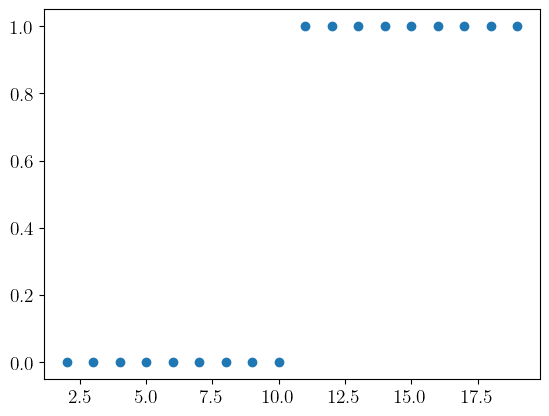

In [30]:
subset = df[(df['Tstart'] == 1000) & (df['rm'] == 0.2) & (df['label'] == 'Shearlets')]          
x, y = subset['ls_iterations'].iloc[0], subset['ls_NMSE'].iloc[0]

y = np.array(y)

fig, ax = plt.subplots()
# ax.plot(x,y, 'o')
ax.plot(x[1:],np.diff(y)>0, 'o')
plt.show()


# Plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


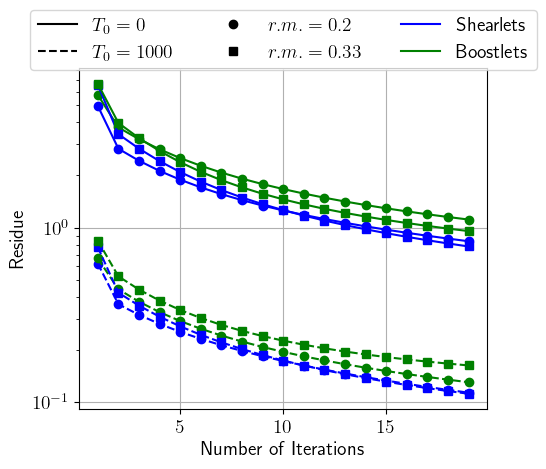

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# Estilos para cada categoría
line_styles = ['-', '--', ':', '-.']  # Estilos de línea para Tstart
markers = ['o', 's', '^', 'D']       # Marcadores para rm
colors = ['b', 'g', 'r', 'c']        # Colores para label

# Crear figura
fig, ax = plt.subplots(figsize=(6, 5))

# Obtener valores únicos para las categorías
Tstart_values = df['Tstart'].unique()
rm_values = df['rm'].unique()
label_values = df['label'].unique()

# Diccionarios para asignar estilos
line_style_map = {Tstart: line_styles[i % len(line_styles)] for i, Tstart in enumerate(Tstart_values)}
marker_map = {rm: markers[i % len(markers)] for i, rm in enumerate(rm_values)}
color_map = {label: colors[i % len(colors)] for i, label in enumerate(label_values)}

# Iterar sobre combinaciones únicas de Tstart, rm y label
for Tstart in Tstart_values:
    for rm in rm_values:
        for label in label_values:
            # Filtrar los datos para la combinación actual
            subset = df[(df['Tstart'] == Tstart) & (df['rm'] == rm) & (df['label'] == label)]          

            # Graficar ls_iterations vs ls_residue
            ax.plot(
                subset['ls_iterations'].iloc[0], subset['ls_residue'].iloc[0], 
                linestyle=line_style_map[Tstart],
                marker=marker_map[rm],
                color=color_map[label],
                label=f'Tstart={Tstart}, rm={rm}, label={label}'
            )


legend_elements = [
    Line2D([0], [0], color='k', linestyle='-', label=r'$T_0=0$'),
    Line2D([0], [0], color='k', linestyle='--', label=r'$T_0=1000$'),
    Line2D([0], [0], color='k', marker='o', linestyle='', label=r'$r.m.=0.2$'),
    Line2D([0], [0], color='k', marker='s', linestyle='', label=r'$r.m.=0.33$'),
    Line2D([0], [0], color='b', linestyle='-', label='Shearlets'),
    Line2D([0], [0], color='g', linestyle='-', label='Boostlets')
]
# Configurar la leyenda personalizada
ax.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.2))

# Configurar el gráfico
ax.set_xlabel("Number of Iterations")
ax.set_ylabel("Residue")
ax.set_yscale('log')
ax.grid(True)

# Mostrar el gráfico# Mostrar el gráfico
plt.tight_layout(rect=(0, 0, 0.9, 1)) # solves a problem where the right part of the plot is missing in .eps
plt.savefig(f'{figs_outputs_dir}/Residual_{room}.eps', format='eps', bbox_inches='tight')
plt.savefig(f'{figs_outputs_dir}/Residual_{room}.jpg', format='jpg', bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


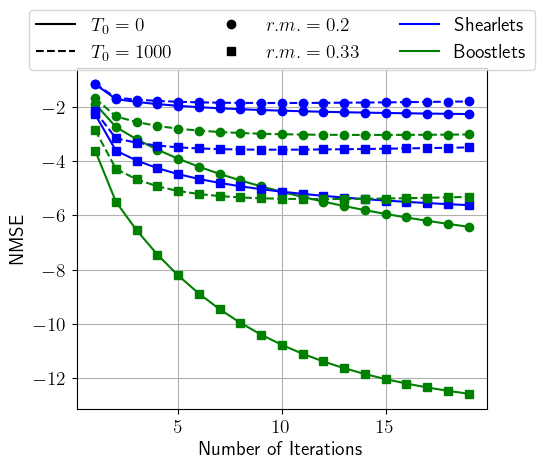

In [ ]:

# Estilos para cada categoría
line_styles = ['-', '--', ':', '-.']  # Estilos de línea para Tstart
markers = ['o', 's', '^', 'D']       # Marcadores para rm
colors = ['b', 'g', 'r', 'c']        # Colores para label

# Crear figura
fig, ax = plt.subplots(figsize=(6, 5))

# Obtener valores únicos para las categorías
Tstart_values = df['Tstart'].unique()
rm_values = df['rm'].unique()
label_values = df['label'].unique()

# Diccionarios para asignar estilos
line_style_map = {Tstart: line_styles[i % len(line_styles)] for i, Tstart in enumerate(Tstart_values)}
marker_map = {rm: markers[i % len(markers)] for i, rm in enumerate(rm_values)}
color_map = {label: colors[i % len(colors)] for i, label in enumerate(label_values)}

# Iterar sobre combinaciones únicas de Tstart, rm y label
for Tstart in Tstart_values:
    for rm in rm_values:
        for label in label_values:
            # Filtrar los datos para la combinación actual
            subset = df[(df['Tstart'] == Tstart) & (df['rm'] == rm) & (df['label'] == label)]          

            # Graficar ls_iterations vs ls_residue
            ax.plot(
                subset['ls_iterations'].iloc[0], subset['ls_NMSE'].iloc[0], 
                linestyle=line_style_map[Tstart],
                marker=marker_map[rm],
                color=color_map[label],
                label=f'Tstart={Tstart}, rm={rm}, label={label}'
            )


legend_elements = [
    Line2D([0], [0], color='k', linestyle='-', label=r'$T_0=0$'),
    Line2D([0], [0], color='k', linestyle='--', label=r'$T_0=1000$'),
    Line2D([0], [0], color='k', marker='o', linestyle='', label=r'$r.m.=0.2$'),
    Line2D([0], [0], color='k', marker='s', linestyle='', label=r'$r.m.=0.33$'),
    Line2D([0], [0], color='b', linestyle='-', label='Shearlets'),
    Line2D([0], [0], color='g', linestyle='-', label='Boostlets')
]
# Configurar la leyenda personalizada
ax.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.2))

# Configurar el gráfico
ax.set_xlabel("Number of Iterations")
ax.set_ylabel("NMSE")
# ax.set_yscale('log')
ax.grid(True)

# Mostrar el gráfico# Mostrar el gráfico
plt.tight_layout(rect=(0, 0, 0.9, 1)) # solves a problem where the right part of the plot is missing in .eps
plt.savefig(f'{figs_outputs_dir}/NMSE_{room}.eps', format='eps', bbox_inches='tight')
plt.savefig(f'{figs_outputs_dir}/NMSE_{room}.jpg', format='jpg', bbox_inches='tight')
plt.show()